<a href="https://colab.research.google.com/github/mjornada/objectDetection/blob/main/modeloResnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as T
import os
import xml.etree.ElementTree as ET
from PIL import Image,ImageDraw
from IPython.display import display
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import numpy as np
#from mapeval import voc_eval

In [ ]:
os.chdir('/content/drive/MyDrive')
!ls

'Colab Notebooks'	'Instruções P1 AL on line.pdf'
'covid (1).gsheet'	 modeloResnet.ipynb
 covid.csv		 objetos
 covid.gsheet		'Planilha sem título.gsheet'
 COVID.metadata.gsheet	 pulmoes
 datasets


In [ ]:
os.chdir('/content/drive/MyDrive/objetos')
!ls

20210701_202239.jpg    labels2.csv     labels.csv     objectDetection.ipynb
best_map_labelbox.pth  labels3.gsheet  labels.gsheet  __pycache__
imagens		       labels4.csv     mapeval.py


In [ ]:
from mapeval import voc_eval

In [ ]:
# dados rotulados de https://www.makesense.ai/
h_files = {}
with open('labels4.csv') as csv_file:
    for line in csv_file:
        v = line.split(',')
        class_att = v[0]
        x1,y1,x2,y2 = [int(x) for x in v[1:5]]
        img_file = v[5]
        if img_file not in h_files.keys():
            h_files[img_file] = {'boxes':[],'labels':[]}
        h_files[img_file]['boxes'].append((x1,y1,x2,y2)) 
        h_files[img_file]['labels'].append(class_att)

for img_file in h_files.keys():
    print(img_file)
    print(h_files[img_file]['boxes'])
    print(h_files[img_file]['labels'])

20210701_195955.jpg
[(1355, 864, 455, 369), (675, 522, 239, 329), (135, 950, 1053, 230), (383, 765, 792, 306), (1206, 711, 315, 108), (1350, 779, 639, 252), (1463, 612, 230, 252)]
['chaveiro', 'isqueiro', 'caneta', 'controle', 'pendrive', 'gaita', 'carro']
20210701_200012.jpg
[(914, 788, 243, 252), (563, 617, 248, 347), (1062, 1031, 315, 518), (500, 972, 459, 590), (302, 945, 198, 230), (1436, 1080, 581, 482), (1350, 882, 225, 216)]
['chaveiro', 'isqueiro', 'caneta', 'controle', 'pendrive', 'gaita', 'carro']
20210701_200016.jpg
[(761, 954, 212, 257), (396, 864, 225, 374), (1112, 1175, 833, 410), (815, 1157, 963, 630), (383, 1283, 351, 248), (1494, 1098, 662, 374), (1175, 990, 230, 176)]
['chaveiro', 'isqueiro', 'caneta', 'controle', 'pendrive', 'gaita', 'carro']
20210701_200025.jpg
[(1098, 864, 212, 216), (828, 711, 212, 293), (941, 1134, 261, 392), (360, 1004, 698, 455), (504, 968, 234, 144), (1301, 1166, 320, 414), (1422, 977, 221, 180)]
['chaveiro', 'isqueiro', 'caneta', 'controle',

In [ ]:
def resize(img,boxes,size):
    w, h = img.size
    ow, oh = size
    sw = float(ow) / w
    sh = float(oh) / h
    img = img.resize((ow,oh), Image.BILINEAR)
    boxes = boxes * torch.tensor([sw,sh,sw,sh])
    return img, boxes

In [ ]:
size = (300,300)
def transform_data(img,boxes):
    img,boxes = resize(img,boxes,size)
    img = T.Compose([
          T.ToTensor(), 
          T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))          
    ])(img)
    return img,boxes

In [ ]:
class MyDataset():
    def __init__(self,transforms = None):
        self.data = []
        self.transforms = transforms
        self.target_names = ['blanck']
        self.htarget_names = {'blanck':0,'caneta':1,'carro':2, 'chaveiro':3,'controle':4, 'gaita':5,'isqueiro':6, 'pendrive':7}
        self.read_csv()

    def get_label_id(self,name):
        if name not in self.htarget_names:
            self.htarget_names[name] = len(self.target_names)
            self.target_names.append(name)
        return self.htarget_names[name]
    
    def read_csv(self):
        h_files = {}
        with open('labels4.csv') as csv_file:
            for line in csv_file:
                v = line.split(',')
                class_att = v[0]
                x1,y1,width,height = [int(x) for x in v[1:5]]
                x2 = x1 + width
                y2 = y1 + height
                img_file = v[5]
                if img_file not in h_files.keys():
                    h_files[img_file] = {'boxes':[],'labels':[]}
                h_files[img_file]['boxes'].append((x1,y1,x2,y2)) 
                h_files[img_file]['labels'].append(self.get_label_id(class_att))

        for img_file in h_files.keys():
            h = {}
            h['file_img'] = 'imagens/'+img_file
            h['labels'] = h_files[img_file]['labels']
            h['boxes']  = h_files[img_file]['boxes']
            self.data.append(h)


    def read_json(self):
        with open('labels4.json') as json_file:
            data = json.load(json_file)
            for h in data:
                if 'objects' in h['Label']:
                    file_url = h['Labeled Data']
                    file_name = 'imagens'+os.sep+h['External ID']
                    objects = h['Label']['objects']
                    boxes = []
                    labels = []
                    for obj in objects:
                        labels.append(self.get_label_id(obj['value']))
                        x1 = int(obj['bbox']['left'])
                        y1 = int(obj['bbox']['top'])
                        #x2 = int(obj['bbox']['width'])
                        #y2 = int(obj['bbox']['height'])
                        x2 = x1 + int(obj['bbox']['width'])
                        y2 = y1 + int(obj['bbox']['height'])
                        bbox  = [x1,y1,x2,y2]
                        boxes.append(bbox)
                    h = {}
                    h['file_img'] = file_name
                    h['labels'] = labels
                    h['boxes']  = boxes
                    self.data.append(h)
    def __getitem__(self,i):
        img   = Image.open(self.data[i]['file_img']).convert("RGB")
        boxes = torch.tensor(self.data[i]['boxes'])
        if self.transforms != None:
            img,boxes = self.transforms(img,boxes)
        r = dict()
        r['boxes']   = boxes
        r['labels']  = torch.tensor(self.data[i]['labels'])
        return img,r
    def __len__(self):
        return len(self.data)    

In [ ]:
#def resize(img,boxes,size):
#    w, h = img.size
#    ow, oh = size
#    sw = float(ow) / w
#    sh = float(oh) / h
#    img = img.resize((ow,oh), Image.BILINEAR)
#    boxes = boxes * torch.tensor([sw,sh,sw,sh])
#    return img, boxes

In [ ]:
#size = (300,300)
#def transform_data(img,boxes):
#    img,boxes = resize(img,boxes,size)
#    img = T.Compose([
#          T.ToTensor(), 
#          T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))          
#    ])(img)
#    return img,boxes

In [ ]:
#transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

In [ ]:
data = MyDataset(transforms=transform_data)

In [ ]:
#falta validacao
n = len(data)
n_treino = int(0.7*n)
n_teste  = n-n_treino
n_valid = int(0.2*n_treino)
n_treino = n_treino-n_valid

In [ ]:
n,n_treino,n_teste, n_valid

(199, 112, 60, 27)

In [ ]:
#ds_treino,ds_teste = torch.utils.data.random_split(data,(n_treino,n_teste))
ds_treino,ds_teste,ds_valid = torch.utils.data.random_split(data,(n_treino,n_teste,n_valid))

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
dl_treino = torch.utils.data.DataLoader(ds_treino,batch_size = 12,collate_fn=collate_fn)
dl_teste  = torch.utils.data.DataLoader(ds_teste,batch_size = 12,collate_fn=collate_fn)
dl_valid  = torch.utils.data.DataLoader(ds_valid,batch_size = 12,collate_fn=collate_fn)

In [ ]:
img,targets = next(iter(dl_treino))

In [ ]:
len(img)

12

In [ ]:
nview = Image.open(data.data[0]['file_img'])

In [ ]:
data.data[0]['boxes']

[(1355, 864, 1810, 1233),
 (675, 522, 914, 851),
 (135, 950, 1188, 1180),
 (383, 765, 1175, 1071),
 (1206, 711, 1521, 819),
 (1350, 779, 1989, 1031),
 (1463, 612, 1693, 864)]

In [ ]:
def draw_boxes(img,boxes,labels):
    imdraw = ImageDraw.Draw(img)
    for (box,label) in zip(boxes,labels):
        box = list(box)
        imdraw.rectangle(box,outline='red')
        text = "%d"%(label)
        imdraw.text((box[0],box[1]),text,fill='red')
    display(img)

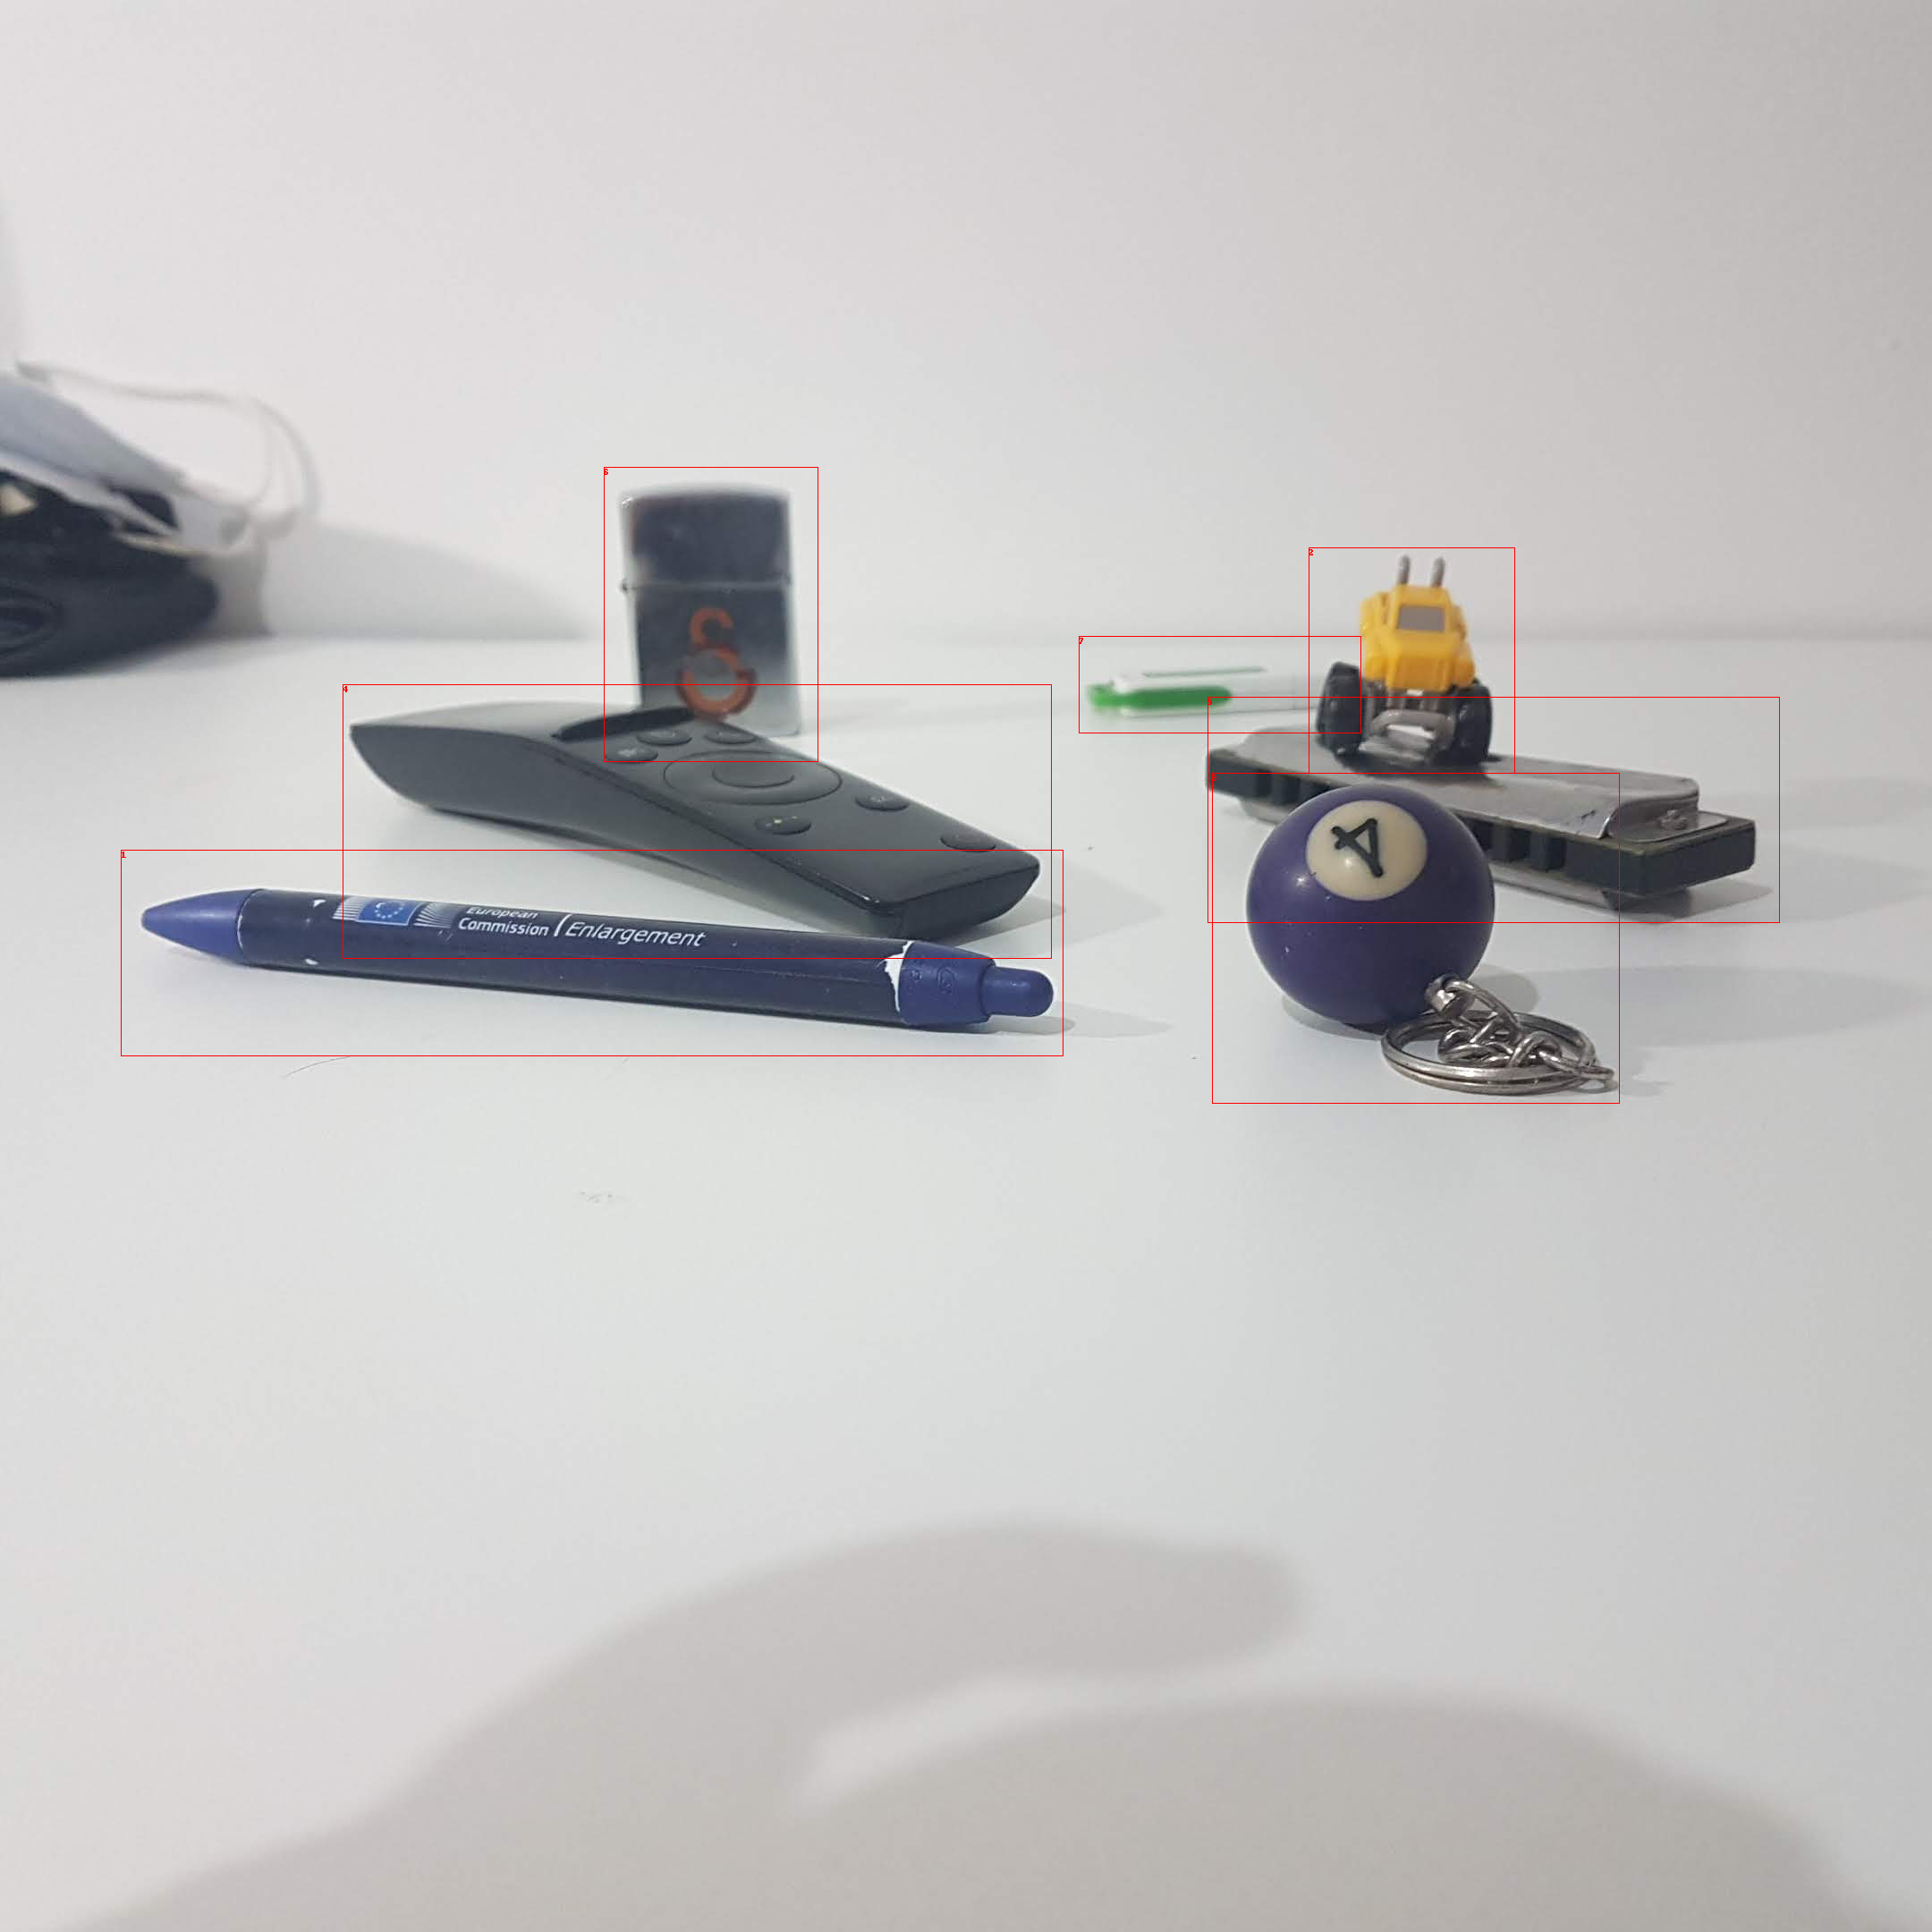

In [ ]:
draw_boxes(nview,data.data[0]['boxes'],data.data[0]['labels'])

In [ ]:
nview = T.ToPILImage()(img[0]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))

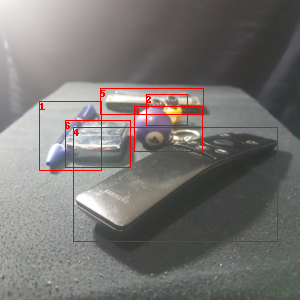

In [ ]:
draw_boxes(nview,targets[0]['boxes'],targets[0]['labels'])

In [ ]:
#model = torchvision.models.mobilenet_v3_small(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#model.classifier[3] = nn.Linear(1024,8)
# Fine tunning
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,8)

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def train(epoch):
    model.train()
    bloss=[]
    for images,targets in dl_treino:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        
        opt.zero_grad()
        losses.backward()
        opt.step()
        #print(loss_dict)
        #wlog = {}
        for loss in loss_dict.keys():
            print("%.10s %4.3f"%(loss,loss_dict[loss].item()))
        print("Total Loss %4.3f\n"%(losses))
        bloss.append(losses.item())
    
    print("\nEPOCH %d LR %5.5f\n"%(epoch,opt.param_groups[0]['lr']))

In [ ]:
def evaluate(epoch):
    model.eval()
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    gt_boxes = []
    gt_labels = []
    lmap = []
    lap  = []
    with torch.no_grad():
        for images,targets in dl_teste:
            images = list(image.to(device) for image in images)
            pred   = model(images)
            for i in range(len(targets)):
                gt_boxes.append(targets[i]['boxes'])
                gt_labels.append(targets[i]['labels'])
                pred_boxes.append(pred[i]['boxes'].cpu())
                pred_labels.append(pred[i]['labels'].cpu())
                pred_scores.append(pred[i]['scores'].cpu())
                r = voc_eval(pred_boxes, pred_labels, pred_scores,
                gt_boxes, gt_labels)
                print(r)
                lmap.append(r['map'])
                #lap.append(r['ap'])
    print(np.mean(lmap))
    #print(np.mean(lap,axis=0))
    return np.mean(lmap)

In [ ]:
best_map = 0.0

In [ ]:
for epoch in range(10):
    train(epoch)
    map = evaluate(epoch)
    lr_scheduler.step(1.0-map)
    if map > best_map:
        best_map = map
        torch.save(model,'best_map_labelbox.pth')
        print('saving model')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan]), 'map': 0.6197781491003579}
{'ap': array([       nan, 0.57869782, 0.71978498, 0.6282438 , 0.70470615,
       0.54548622, 0.53402742, 0.64748395,        nan,        nan,
              nan,        nan,        nan,

In [ ]:
#nview = Image.open(data.data[0]['file_img'])
best_map

0.7041274424188979

In [ ]:
#nview = T.ToPILImage()(img[-1]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#pred   = model(img[-1].view([1,3,300,300]).to(device))

In [ ]:
#for aux in range(40):
#for img in dl_treino:
#  pred = best_map(img[-1].view([1,3,300,300]).to(device))
#  pred
#pred

In [ ]:
#draw_boxes(nview,pred[0]['boxes'],pred[0]['labels'])

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
#for aux in range(40):
#for img in dl_treino:
  #nview = Image.open(data.data[0]['file_img'])
  #img,targets = next(iter(dl_teste))
#imagem,targets = next(iter(dl_teste))
#nview = T.ToPILImage()(img[-1]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))
#imagem = ds_teste[0]
pred   = model(img[-1].view([1,3,300,300]).to(device))
pred
  #draw_boxes(nview,pred[aux]['boxes'],pred[aux]['labels'])

[{'boxes': tensor([[ 43.6120, 140.9115, 295.8325, 206.9705],
          [218.7580, 108.7699, 268.2451, 143.1600],
          [ 74.7167, 117.0612, 117.4849, 142.6389],
          [106.9804, 104.7182, 171.0076, 144.6054],
          [183.3938,  99.5961, 222.3533, 136.6518],
          [ 27.3874, 127.1762, 176.5829, 167.7399],
          [144.8225, 131.4278, 191.5922, 150.8671],
          [143.7400, 128.4881, 193.3160, 158.0972],
          [ 28.1709, 153.8665, 197.9075, 213.9219],
          [ 74.2105, 106.5169, 208.8554, 144.3614],
          [107.6664, 133.4132, 299.7224, 187.9612],
          [151.1817, 134.2430, 293.9142, 163.8493],
          [119.9647, 103.3414, 197.2388, 139.2684],
          [ 76.6781, 133.3647, 149.9221, 168.0340],
          [ 29.0263, 120.6575, 194.7547, 169.2977],
          [ 59.3783, 111.3136, 174.8002, 165.9116],
          [184.7675, 101.2088, 220.5856, 116.9866],
          [141.2747, 127.3595, 192.2336, 152.9487],
          [ 70.3948, 116.2434, 114.0456, 144.1857],
   

In [ ]:
aux = 0
for aux in range(60):
  nview = T.ToPILImage()(ds_teste[aux]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))
  pred = model(ds_teste[aux].view([1,3,300,300]).to(device))
  print(pred)
  aux = aux + 1

TypeError: ignored

In [ ]:
aux

10